In [4]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 65 Jun 21 06:08 kaggle.json
100% 3.58G/3.58G [01:23<00:00, 42.6MB/s]
100% 3.58G/3.58G [01:23<00:00, 46.1MB/s]


In [5]:
import zipfile
import os

curDir = os.getcwd()
print(curDir)

local_zip = '/content/fruits-fresh-and-rotten-for-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')

zip_ref.close()

/content


(190, 178)


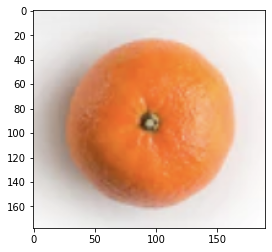

In [6]:
import random
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import os

filenames = os.listdir('/content/dataset/train/freshoranges')
sample = random.choice(filenames)
image = load_img('/content/dataset/train/freshoranges/'+sample)
plt.imshow(image)
print(image.size)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [15]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=15,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
                    'dataset/train',
                    target_size = (150,150),
                    batch_size = 15,
                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
                    'dataset/test',
                    target_size=(150,150),
                    batch_size= 15,
                    class_mode='categorical'
)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [9]:
## Define a Callback function
desired_accuracy = 0.999


class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>desired_accuracy):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

my_callback = myCallback()

In [10]:
baseModel = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(150, 150, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs = headModel)

# Freeze the baseModel layers
for layer in baseModel.layers :
    layer.trainable = False

94674944/94668760 [==============================] - 2s 0us/step


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
## Hyperparameter
INIT_LR = 1e-3
BS = 15
EPOCHS = 25

In [13]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [22]:
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            steps_per_epoch=len(train_generator) // BS,
            validation_steps=len(validation_generator) // BS,
            epochs=30,
            verbose=1,
            callbacks=[my_callback]
)

Epoch 1/30
48/48 [==============================] - 9s 186ms/step - loss: 0.0054 - accuracy: 0.9944 - val_loss: 0.0305 - val_accuracy: 0.9944
Epoch 2/30
48/48 [==============================] - 9s 177ms/step - loss: 0.0061 - accuracy: 0.9931 - val_loss: 0.0019 - val_accuracy: 0.9944
Epoch 3/30
48/48 [==============================] - 9s 177ms/step - loss: 0.0141 - accuracy: 0.9861 - val_loss: 0.0110 - val_accuracy: 0.9889
Epoch 4/30
48/48 [==============================] - 9s 179ms/step - loss: 0.0083 - accuracy: 0.9931 - val_loss: 0.0031 - val_accuracy: 0.9944
Epoch 5/30
48/48 [==============================] - 9s 183ms/step - loss: 0.0072 - accuracy: 0.9889 - val_loss: 6.4907e-04 - val_accuracy: 1.0000
Epoch 6/30
48/48 [==============================] - 9s 178ms/step - loss: 0.0077 - accuracy: 0.9931 - val_loss: 0.0068 - val_accuracy: 0.9944
Epoch 7/30
48/48 [==============================] - 8s 177ms/step - loss: 0.0114 - accuracy: 0.9833 - val_loss: 0.0011 - val_accuracy: 1.0000
Ep

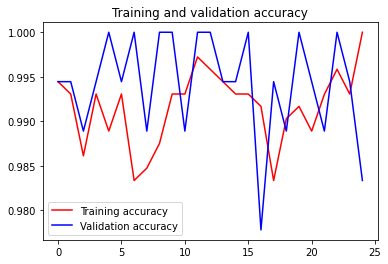

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [24]:
model.save('transfer_learningv4.h5')